In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

In [2]:
TARGET_COL = "duration"
OTHERS = ["interest", "genre_top"]
TEST_SIZE = 0.2
N_SPLITS = 4

## Load merged dataset

In [3]:
df = pd.read_csv("../DataBase/processed/merged_data.csv")
print(df.shape)

(99995, 34)


## Data preprocessing

In [4]:
df = df[df[TARGET_COL].notna()].dropna().copy()
print(df.shape)

(6867, 34)


In [5]:
label_encoder_genre_top = LabelEncoder()
label_encoder_coarse_genre_top = LabelEncoder()

df["genre_top"] = label_encoder_genre_top.fit_transform(df["genre_top"])
df["coarse_genre_top"] = label_encoder_coarse_genre_top.fit_transform(df["coarse_genre_top"])

In [6]:
X = df.drop(columns=[TARGET_COL] + OTHERS)
y = df[TARGET_COL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

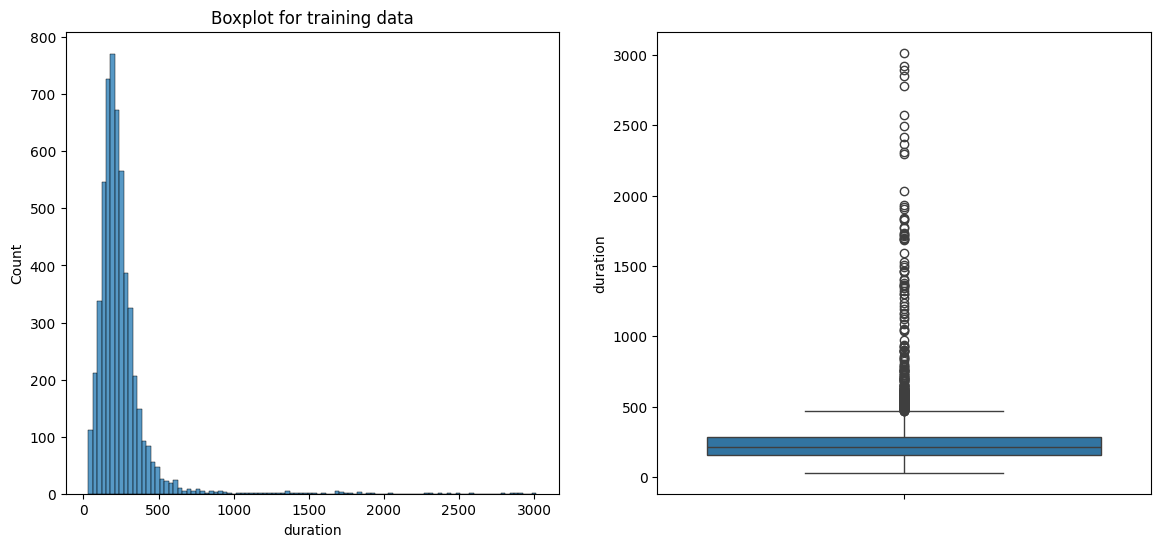

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(y_train, bins=100, ax=axes[0])
axes[0].set_title("Repartition for training data")
sns.boxplot(y_train, ax=axes[1])
axes[0].set_title("Boxplot for training data")
plt.show()

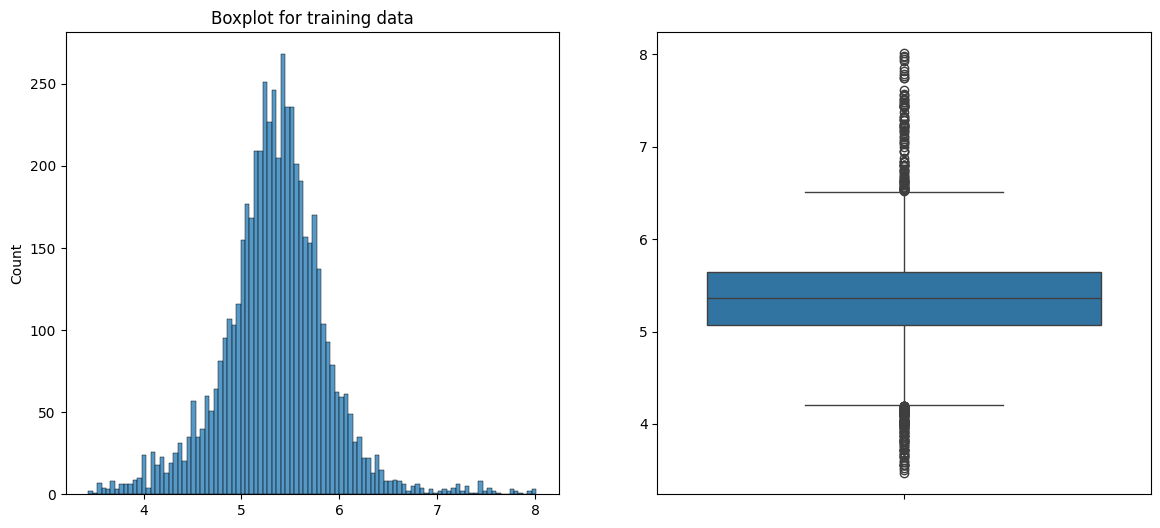

In [8]:
y_train_transformed = [np.log1p(value) for value in y_train]
y_test_transformed = [np.log1p(value) for value in y_test]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot([np.log(value) for value in y_train], bins=100, ax=axes[0])
axes[0].set_title("Repartition for training data")
sns.boxplot([np.log(value + 1) for value in y_train], ax=axes[1])
axes[0].set_title("Boxplot for training data")
plt.show()

## Model training

## With coarse_genre_top GroupKFold

In [9]:
group_kfold = KFold(N_SPLITS)

In [10]:
def inv_transform(value):
    return np.exp(value) - 1

### SVM

In [11]:
svm = SVR()

scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	svm,
	X_train,
	y_train_transformed,
	cv=group_kfold,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {-np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 0.5225 +- 0.0073
MSE: 0.2731 +- 0.0076
r2: -0.0359 +- 0.0042


In [12]:
svm.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.5598
MSE:, 0.3134
r2: 0.0276
----------------------
Metrics in original space:
RMSE: 218.2000
MSE:, 47611.2258
r2: -0.0108


### Random Forest

In [13]:
random_forest = RandomForestRegressor()

scoring = ["neg_root_mean_squared_error", "neg_mean_squared_error", "r2"]
scores = cross_validate(
	random_forest,
	X_train,
	y_train,
	cv=group_kfold,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {-np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 183.0177 +- 8.7159
MSE: 33571.4553 +- 3200.2674
r2: -0.1298 +- 0.0673


In [14]:
random_forest.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.5598
MSE:, 0.3134
r2: 0.0276
----------------------
Metrics in original space:
RMSE: 218.2000
MSE:, 47611.2258
r2: -0.0108


### XGBoost

In [15]:
xgb = XGBRegressor()

scores = cross_validate(
	random_forest,
	X_train,
	y_train,
	cv=group_kfold,
	scoring=scoring
)

print(f"RMSE: {-np.mean(scores["test_neg_root_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_root_mean_squared_error"]):.4f}")
print(f"MSE: {-np.mean(scores["test_neg_mean_squared_error"]):.4f} +- {np.std(scores["test_neg_mean_squared_error"]):.4f}")
print(f"r2: {-np.mean(scores["test_r2"]):.4f} +- {np.std(scores["test_r2"]):.4f}")

RMSE: 184.4035 +- 8.3640
MSE: 34074.6078 +- 3089.3777
r2: -0.1162 +- 0.0700


In [16]:
xgb.fit(X_train, y_train_transformed)
predictions = svm.predict(X_test)
inv_predictions = [inv_transform(value) for value in predictions]
print("Metrics in transformed space:")
print(f"RMSE: {root_mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test_transformed, predictions):.4f}")
print(f"r2: {r2_score(y_test_transformed, predictions):.4f}")
print("----------------------")
print("Metrics in original space:")
print(f"RMSE: {root_mean_squared_error(y_test, inv_predictions):.4f}")
print(f"MSE:, {mean_squared_error(y_test, inv_predictions):.4f}")
print(f"r2: {r2_score(y_test, inv_predictions):.4f}")

Metrics in transformed space:
RMSE: 0.5598
MSE:, 0.3134
r2: 0.0276
----------------------
Metrics in original space:
RMSE: 218.2000
MSE:, 47611.2258
r2: -0.0108


### Without coarse_genre_top GroupKFold